In [1]:
!pip install split_folders

In [36]:
import os
import splitfolders
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
import warnings
warnings.filterwarnings("ignore")

In [2]:

def preprocess_data():
    

    normalization = Rescaling(1./255)

    return tf.keras.Sequential([
        normalization
    ])

preprocessing_function = preprocess_data()

loc = "/kaggle/input/autism-image-data/AutismDataset/consolidated"
os.makedirs('output', exist_ok=True)
os.makedirs('output/train', exist_ok=True)
os.makedirs('output/val', exist_ok=True)
os.makedirs('output/test', exist_ok=True)
splitfolders.ratio(loc, output="output", seed=42, ratio=(0.80, 0.1, 0.1))

train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"



train_data = image_dataset_from_directory(
    train_dir, 
    batch_size=32, 
    image_size=(224, 224), 
    label_mode='categorical', 
    shuffle=True, 
    seed=42
).map(lambda x, y: (preprocessing_function(x), y))

test_data = image_dataset_from_directory(
    test_dir, 
    batch_size=32, 
    image_size=(224, 224), 
    label_mode='categorical', 
    shuffle=False, 
    seed=42
).map(lambda x, y: (preprocessing_function(x), y))

val_data = image_dataset_from_directory(
    val_dir, 
    batch_size=32, 
    image_size=(224, 224), 
    label_mode='categorical', 
    shuffle=False, 
    seed=42
).map(lambda x, y: (preprocessing_function(x), y))

Copying files: 2940 files [00:23, 123.12 files/s]


Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [5]:
!pip install evaluate


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:0000:01


In [40]:
from datasets import load_dataset
from evaluate import load as load_metric
#model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" 
model_checkpoint="facebook/deit-tiny-patch16-224"
batch_size = 16 # batch size for training and evaluation
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/autism-image-data/AutismDataset/consolidated")


metric = load_metric("accuracy",trust_remote_code=True)
example = dataset["train"][10]
dataset["train"].features

Resolving data files:   0%|          | 0/2940 [00:00<?, ?it/s]

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Autistic', 'Non_Autistic'], id=None)}

In [41]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'Non_Autistic'

In [42]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [43]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    #size=(64,64)
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    #size=64
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [44]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [45]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [47]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, 
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [49]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [50]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [51]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [52]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.623400,0.769311,0.591837
1,0.510900,0.678197,0.646259
2,0.493200,0.480666,0.755102
4,0.424500,0.359150,0.819728
5,0.373700,0.359575,0.836735
6,0.367100,0.390147,0.809524
8,0.366400,0.407227,0.795918
9,0.365000,0.370035,0.823129


***** train metrics *****
  epoch                    =      9.6386
  total_flos               = 118548441GF
  train_loss               =      0.4403
  train_runtime            =  0:03:42.20
  train_samples_per_second =     119.077
  train_steps_per_second   =         0.9


Epoch,Training Loss,Validation Loss,Accuracy
0,0.377700,0.496005,0.761905
1,0.361700,0.555044,0.744898
2,0.357800,0.355175,0.826531
4,0.348400,0.390187,0.829932
5,0.300500,0.381780,0.836735
6,0.309000,0.355136,0.846939
8,0.286900,0.396051,0.823129
9,0.281200,0.369502,0.843537


***** train metrics *****
  epoch                    =      9.6386
  total_flos               = 118548441GF
  train_loss               =      0.3282
  train_runtime            =  0:03:42.08
  train_samples_per_second =     119.144
  train_steps_per_second   =       0.901


Accuracy: 0.8469


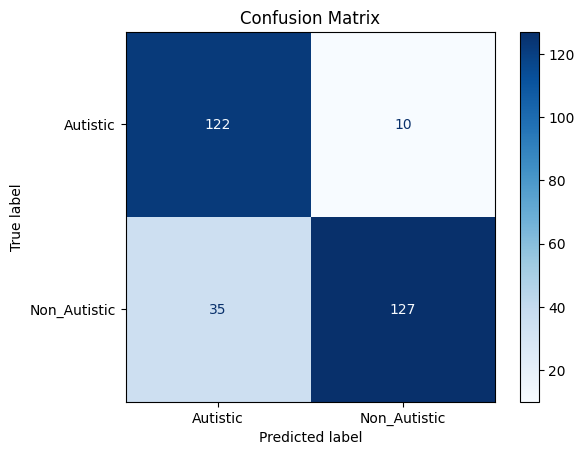

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Add this function to compute the accuracy and confusion matrix
def evaluate_model(trainer):
    # Evaluate the model on the validation dataset
    eval_results = trainer.evaluate()
    
    # Get predictions and true labels
    preds = trainer.predict(val_ds)
    predictions = np.argmax(preds.predictions, axis=1)
    true_labels = preds.label_ids
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)  # or you can use a metric library
    print(f"Accuracy: {accuracy:.4f}")
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=list(label2id.values()))
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# After training the model, call the evaluation function
train_results = trainer.train()
# Save model and metrics
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Call the evaluate_model function
evaluate_model(trainer)


In [29]:
import os
import shutil
from transformers import Trainer
model_dir = trainer.args.output_dir
zip_filename = "/kaggle/working/deit-model.zip"
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', model_dir)

print(f"Model saved and zipped as {zip_filename}")


Model saved and zipped as /kaggle/working/deit-model.zip
